
# Artificial Intelligence - COMPSCI4004/5087 2024-2025

## Lab Week 5: Maximum Expected Utility
<small><small><small>v20242025a</small></small></small>

 <font color=red>SOLUTION</font>

----

**Aim**:

Get hands-experience with utility functions and the maximum utility principle:
* Define and implement a custom utility function
* Implement and compute the expected utility and apply the MEU principle to make rational decisions in an uncertain world

**Guide**:
The notebook contains specific tasks - often open-ended questions - that you'll need to carry out to make the notebook run or be able to understand the next steps. These are indicated with:

* <font color=dark-magenta>TASK:</font> This is a task for you to carry out before proceeding. 
* <font color=green>CHECKPOINTS:</font> This indicates a key point you should understand before proceeding. If you're in doubt then ask then consult the lab assistants.
* A basic model solution (marked with <font color=red>SOLUTION</font>) will be provided a week after the Lab session.

<br>

---

### Q5.0 Introduction & Housekeeping 

The exercise relies on Python 3 and uses some of the utilities in the AIMA toolbox such as BayesNet class and exact inference via enumeration from Week 4. 

__Prerequisites__

Importing these modules from the provided AIMA module should run without error. If you get an error you probably need to update your Python installation.

* <font color=dark-magenta>TASK:</font> Change the AIMA_TOOLBOX_ROOT variable below and run the import statements.

In [1]:
import os, sys
print("Working dir:"+os.getcwd())
print("Python version:"+sys.version)

AIMA_TOOLBOX_ROOT="/Users/debasis/teaching/ai-2023/aima-python-uofg/"
sys.path.append(AIMA_TOOLBOX_ROOT)


Working dir:/Users/debasis/teaching/ai-2023/labs/lab_week05_meu_solution_v20202021a 2
Python version:3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [3]:
from utils import (
    product, argmax, element_wise_product, matrix_multiplication,
    vector_to_diagonal, vector_add, scalar_vector_product, inverse_matrix,
    weighted_sample_with_replacement, probability, isclose, normalize
)
import random
from collections import defaultdict
from probability import  * 
import numpy as np

----

### Q5.1 The Basics

* <font color=dark-magenta>TASK:</font> Review MEU principle in the AIMA book (Ch 16) or lectures notes. Write down the equation for computing expected utility and define the maximum expected utility principle?

-----
### Q5.2 Case Study

In order to exploit Bayesian Networks in decision making (as a modelling tool), we'll consider a concrete problem.

Economists often make use of an exponential utility function for money: 

$$U(x) = -\exp( -x / F)\,,$$

where x is the monetary value of money and F is a positive constant representing an individual’s risk tolerance. Risk tolerance reflects how likely an individual is to accept a lottery with a particular expected monetary value (EMV) versus some certain payoff. As F (which is measured in the same units as x) becomes larger, the individual becomes less risk-averse.

Assume Mary has an exponential utility function with F = 300. Mary is given the choice between:

- a) receiving £400 for sure (with probability 1.0) 

- b) participating in a lottery which has a 60% probability of winning £5000 and a 40% probability of winning nothing. 

Assuming Mary acts rationally, which option would she choose? You may already know this if you have done the quiz but let' try to solve the problem in Python (whole of question 6.2) which will allow us to easily examine what happens if we change F/the utility function)

---
#### Q5.2.0 Inspecting the utility function

* <font color=dark-magenta>TASK: </font> Plot the graph for the utility function for F=100,200,400 and 1000 (e.g. using matplotlib) in the interval $x=[-200, 5000]$. Explain how you can tell that a person with F=100 is more risk-averse than one with F=1000 ?

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

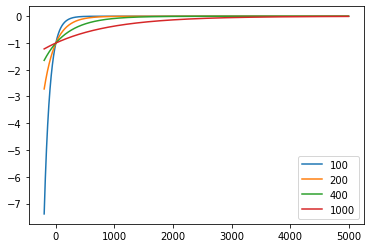

In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-200,5000)

F = 100
u100 = -np.exp( - x / 100)
u200 = -np.exp( - x / 200)
u400 = -np.exp( - x / 400)
u1000 = -np.exp( - x / 1000)

plt.plot(x,u100)
plt.plot(x,u200)
plt.plot(x,u400)
plt.plot(x,u1000)
plt.legend(('100','200','400','1000'))


The person currently has an option between leaving with £400 or enter a lottery (60% for winning £5000, 40% of getting nothing). A person with F=100 sees no (significant) difference in having £400 and £5000, but a clear benefit in having £400 over £0, thus this person is less likely to  enter a lottery (risk averse). A person with F=1000 sees a significant benefit of £5000 over £400 and more willing to enter a lottery (i.e. less risk averse).

<div style="border:2px solid red"></div>

----
#### Q5.2.1 Modelling with a Bayesian Network
We'll define a Bayesian decision network to model the problem. We need to represent the action node and any observations nodes. 

The action node is simply treated as a random variable which has two outcomes: bet or not bet. We can initialise it to 50% but at some point we will assume that we have observed it, i.e., it becomes evidence.

The observations are a random variable, MonetaryValue with outcomes £0, 400, 5000, i.e. a random variable with three outcome. However, we can also think of it in terms of two binary variables Win 400 and Win5000 with the following correspondence between the two variables and the MonetaryValue


Win400 |  Win5000 | MonetaryValue <br>
F&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |        F   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   | 0 <br>
F&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |        T   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   | 5000 <br>
T&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |        F   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   | 400 <br>
T&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |        T   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   | -1000 (this is actually not allowed; so you're cheating if it happens we'll set it to -1000) <br>




We furthermore exploit that the two variables can be modelled as being conditional independent if we know the outcome of Bet. 

* <font color=dark-magenta>TASK:</font> Write out the conditional distribution $$P(Win400, Win5000|Bet)$$ assuming the two variables are conditionally independent (hint: you just need to apply the product rule and exploit the fact that we assume conditional independence).


* <font color=darkgreen>CHECKPOINT</font>: Verify your result with the lab group and/or the lab assistance before moving on!

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>
$$P(Win400,Win5000|Bet) = P(Win400|Bet)P(Win5000|Bet)$$
<div style="border:2px solid red"></div>

* <font color=dark-magenta>TASK:</font> The next step is to define the probability distribution for the two variables and the action. I.e. determine the following values from the formulation of the problem:


$$P(Win400=False|Bet=True)$$
$$P(Win400=True|Bet=True)$$
$$P(Win400=False|Bet=False)$$
$$P(Win400=True|Bet=False)$$

$$P(Win5000=False|Bet=True)$$
$$P(Win5000=True|Bet=True)$$
$$P(Win5000=False|Bet=False)$$
$$P(Win5000=True|Bet=False)$$

* <font color=green>CHECKPOINTS:</font> We suggest you discuss your solution to this with the tutors. A couple of checks; can you win both 400 and 5000 in your definition when betting?

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

<imf href='./resources/cpt.png'>


$$P(Win400=False|Bet=True)= 1.0 $$
$$P(Win400=True|Bet=True) = 0.0$$
$$P(Win400=False|Bet=False) = 0.0$$
$$P(Win400=True|Bet=False) = 1.0 $$

$$P(Win5000=False|Bet=True) = 0.4$$
$$P(Win5000=True|Bet=True) = 0.6$$
$$P(Win5000=False|Bet=False) = 1.0$$
$$P(Win5000=True|Bet=False) = 0.0$$

A quick sanity check: Make sure your probability distrbutions sum to one (given a specific conditioning variable), i.e. $P(Win400=False|Bet=True) + P(Win400=True|Bet=True) = 1.0$.






<div style="border:2px solid red"></div>

* <font color=dark-magenta>TASK:</font> Sketch the Bayesian/decision network implied by the above formulation (with three nodes) and the respective CPTs.

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

<img src="./resources/cpt.png">


<div style="border:2px solid red"></div>

---

#### Q5.2.2 Modelling with a Bayesian Network

We now want to implement the Bayesian/Decision network in Python. There are several ways to do this but we will continue using the `AIMA toolbox` exploiting the access to functions which allows easy inference (which is useful in more complicated networks but maybe a bit overkill here).

* <font color=dark-magenta>TASK: </font>Complete the definition below to define the Bayes net 

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

In [6]:
# After inserting the values found in Q5.2.1

gamebn = BayesNet([    
    ('Action_bet'   , ''           , 0.5),  # 50% for action or not (doesn't matter)
    ('Win400'       , 'Action_bet' , {True: 0.0  , False: 1.0}), # i.e. if Action_bet=True I always get 400, otherwise there is no chance to get, i.e. Win400=False
    ('Win5000'      , 'Action_bet' , {True: 0.6  , False: 0.0}), # i.e. if Action_bet=False I NEVER get 5000, otherwise there is 60% chance of getting 400
    ])

result_nodes = ['Win400', 'Win5000']
action_nodes = ['Action_bet']

print(gamebn)

BayesNet([('Action_bet', ''), ('Win400', 'Action_bet'), ('Win5000', 'Action_bet')])


<div style="border:2px solid red"></div>

---

#### Q5.2.3 Implementing the utility function
We know from the problem definition how we can map from money to utility via the exp function, so we can now define a custom implementation of the utility function  (here the state captures the value of both Win400 and Win5000)

* <font color=dark-magenta>TASK: </font> Implement a function that takes as input the state of Win400 and Win5000 variables and returns the utility. Hint: you effectively need to implement the truth table in Q5.2.

In [7]:
def my_utility_function(state, F):
    # Inputs
    #  state is a dict, e.g. state['Node1']
    #      state['Node1'] correspond to the state of the Win400 variable
    #      state['Node2'] correspond to the state of the Win5000 variable
    #
    #  F is a scalar
    #
    # output
    #     A scalar U
         
    # Step 1: Insert code here to map from state to the monetary value using the table above
    # Insert code...
    
    # Step 2: Insert code here to map from monetary value to utility using Eq 1
    # Insert code...
    
    #
    return U

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

In [8]:
def my_utility_function(state, F):
    # Inputs
    #  state is a dict, e.g. state['Node1']
    #      state['Node1'] correspond to the state of the Win400 variable
    #      state['Node2'] correspond to the state of the Win5000 variable
    #
    #  F is a scalar
    #
    # output
    #     A scalear U
    #
    
    monetary_value = 0

    if(  state['Node1']==False and state['Node2']==False):
        monetary_value = 0.0
    elif(state['Node1']==False and state['Node2']==True):
        monetary_value = 5000.0
    elif(state['Node1']==True  and state['Node2']==False):
        monetary_value = 400.0
    elif(state['Node1']==True  and state['Node2']==True):
        monetary_value = -1000.0 # you are cheating! note: we rely on the probability of this happing being 0.0
    else:
        print('Error')

    # Then map from money to utility
    U = -np.exp(-monetary_value / F)
    return U

<div style="border:2px solid red"></div>

----

#### Q5.3.4 Computing $p(result|action,evidence)$


Expected utility is computed using the general equation:

$$EU(action|evidence) = \sum\limits_{s'}^{} {p(s'|action,evidence)U(s')} $$

i.e. it relies on the utility function and the conditional distributions. The BayesNet object (AIMA toolbox) allows us easily compute P(s'|evidence,action) (that's why we are using it!), however it does not allow us to directly compute it when s contains two random variables/nodes such as $P(Win400,Win5000|evidence,action)$ which we need in this case. We will therefore implement a function for computing the conditional of the outcome variables if taking an action, i.e. $P(Result(Action) | Evidence)=P(Win400,Win5000|Action\_Bet)$ where the evidence contains the action_bet node.

We will (later) exploit the conditional independence from quetsion Q5.2.1, i.e. 
<br>

$$P(Win400,Win5000|Action\_Bet)=P(Win5000|Bet)P(Win400|Action\_Bet)$$ 

so we only need to compute the two simple conditionals using the `enumeration_ask` function from last week.


* <font color=dark-magenta>TASK: </font>Inspect the code below and verify that you understand how the it can be used to compute conditionals of the form P(Win400|Bet) and P(Win5000|Bet)

In [10]:
def my_conditionals(result_nodes,action_and_evidence_nodes,bn):
    # Inputs
    #     result_nodes: a dict with the variables , e.g. Win400 and Win5000 
    #     evidence_nodes: a dict with the evidence (and action nodes), e.g. Action_Bet
    #     bn: the BayesNet definition
    #
    # Returns
    #     P_nodes_evidence (e.g. P(Win400|action))
    

    P_nodes_evidence = dict()
    for result_node in result_nodes:
        P_nodes_evidence[result_node] = (enumeration_ask(result_node, action_and_evidence_nodes, bn).prob)
    return(P_nodes_evidence)  

----

### Q5.2.5 Defining a function to compute expected maxium utility

In order to compute EU we will implement a custom function which can handle two result variables. 

* <font color=dark-magenta>TASK: </font>Inspect the code below and make sure you understand how this maps to the equation for computing expected utility (this is very important that you understand this function). 

In [11]:
def expected_utility_two_cond_independent_rv(util_func, cond_func, bn, result_nodes, evidence_and_action_nodes, F):
    """    
    Inputs: 
        P_result_nodes__evidence: the conditional distrbution, i.e. P(Node1 | Evidence), P(Node2 | Evidence)
        util_func: a handle to the utility function 
        cond_func: a handle to the funciton that can compute conditionals, e.g. P(Win400|Evidence)
        result_nodes: a list with the names of the nodes
        evidence_and_action_nodes
        F: parameter parsed to the utility function 
    
    Output:
        eu: expected utility
    
    Note: we assume that all nodes in are coditional independent given the evidence !
    """
    
    P_result__evidencen_and_actions = cond_func(result_nodes,evidence_and_action_nodes,bn)
    
    eu = 0.0    
    for node1_outcome in [True,False]: # itereation over possible outcomes of the first Node (e.g. Win400)
        for node2_outcome in [True,False]: # itereation over possible outcomes of the first Node (e.g. Win5000)
            # Compute the P(Node1,Node2 | Evidence) assuming conditional independence
            P_Node1_Node2__Evidence = (P_result__evidencen_and_actions[result_nodes[0]])[node1_outcome] * (P_result__evidencen_and_actions[result_nodes[1]])[node2_outcome]
            
            # Compute the utility for the specific state
            state = dict(Node1=node1_outcome,Node2=node2_outcome)
            U = util_func(state, F)     
            
            # Insert code to compute the expected given the utility and P(Node1,Node2 | Evidence)
            eu += P_Node1_Node2__Evidence * U 

    return eu

---

### Q5.2.6 Computing the expected utilities.

We are now in a position to compute the arguments required for the `expected_utility_two_cond_independent_rv` function. So let's try to compute the expected utility of making the choice to Bet, i.e.

* <font color=dark-magenta>TASK: </font>According to the maxium expected utility principles, should Mary bet or not ? (would you bet ....?) We've provided code for the Action=Bet=true condition 

In [12]:
F = 300

In [13]:
# First consider Action_bet=true
evidence_and_action_nodes = dict(Action_bet=True)

eu_bet = expected_utility_two_cond_independent_rv(my_utility_function, my_conditionals, gamebn, result_nodes, evidence_and_action_nodes, F)

print("EU(Action_bet=True)=" + str(eu_bet))

EU(Action_bet=True)=-0.40000003466649114


... insert code for computing EU of not betting:

In [14]:
# Insert the code for Action_bet=False and report EU(Action_notbet)

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

In [15]:
# Consider Action_bet=False
evidence_and_action_nodes = dict(Action_bet=False)

eu_not_bet = expected_utility_two_cond_independent_rv(my_utility_function, my_conditionals, gamebn, result_nodes, evidence_and_action_nodes, F)

print("EU(Action_bet=False)=" + str(eu_not_bet))

EU(Action_bet=False)=-0.26359713811572677


- We see that  Action_bet=False has higher EU than Action_bet=True, thus Mary should not bet given her defined utility funciton (but it is close)

<div style="border:2px solid red"></div>

---
### Q5.2.7 How risk averse are you ?.


* <font color=dark-magenta>TASK: </font> Can you make the decision change by modifying Mary's risk tolerance (i.e. the F parameter in the utility function) ? At which F value (roughly) are the two options equally rational? 

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

Higher F means more risky personality (willing to gamble if F e.g. 10000). Low F means less risky personality.

The EU's are roughly the same for F=437, i.e. Mary is indifferent to option of taking the £400 for sure or entering the lottery. 

<br>

<div style="border:2px solid red"></div>

* <font color=dark-magenta>TASK: </font> What is your personal F ?

<div style="border:2px solid red"></div>
<font color="red">SOLUTION</font>

Are you willing to take the bet or would you prefer the £400 ? If willing to take the bet then your (effective) F > (approx) 437 if not then F < approx. 437 

<br>

<div style="border:2px solid red"></div>

---

### Q5.2.8 Alternative implementation... [extra; optional]

* <font color=dark-magenta>TASK [optional]: </font> We have used the AIMA toolbox to represent the Bayesian network as a convenient way to handle general problems - we encourage students to implement a solution only numpy (for this specific problem).

---